Successfully loaded 56 records from /kaggle/input/tweets/Tweets.xlsx


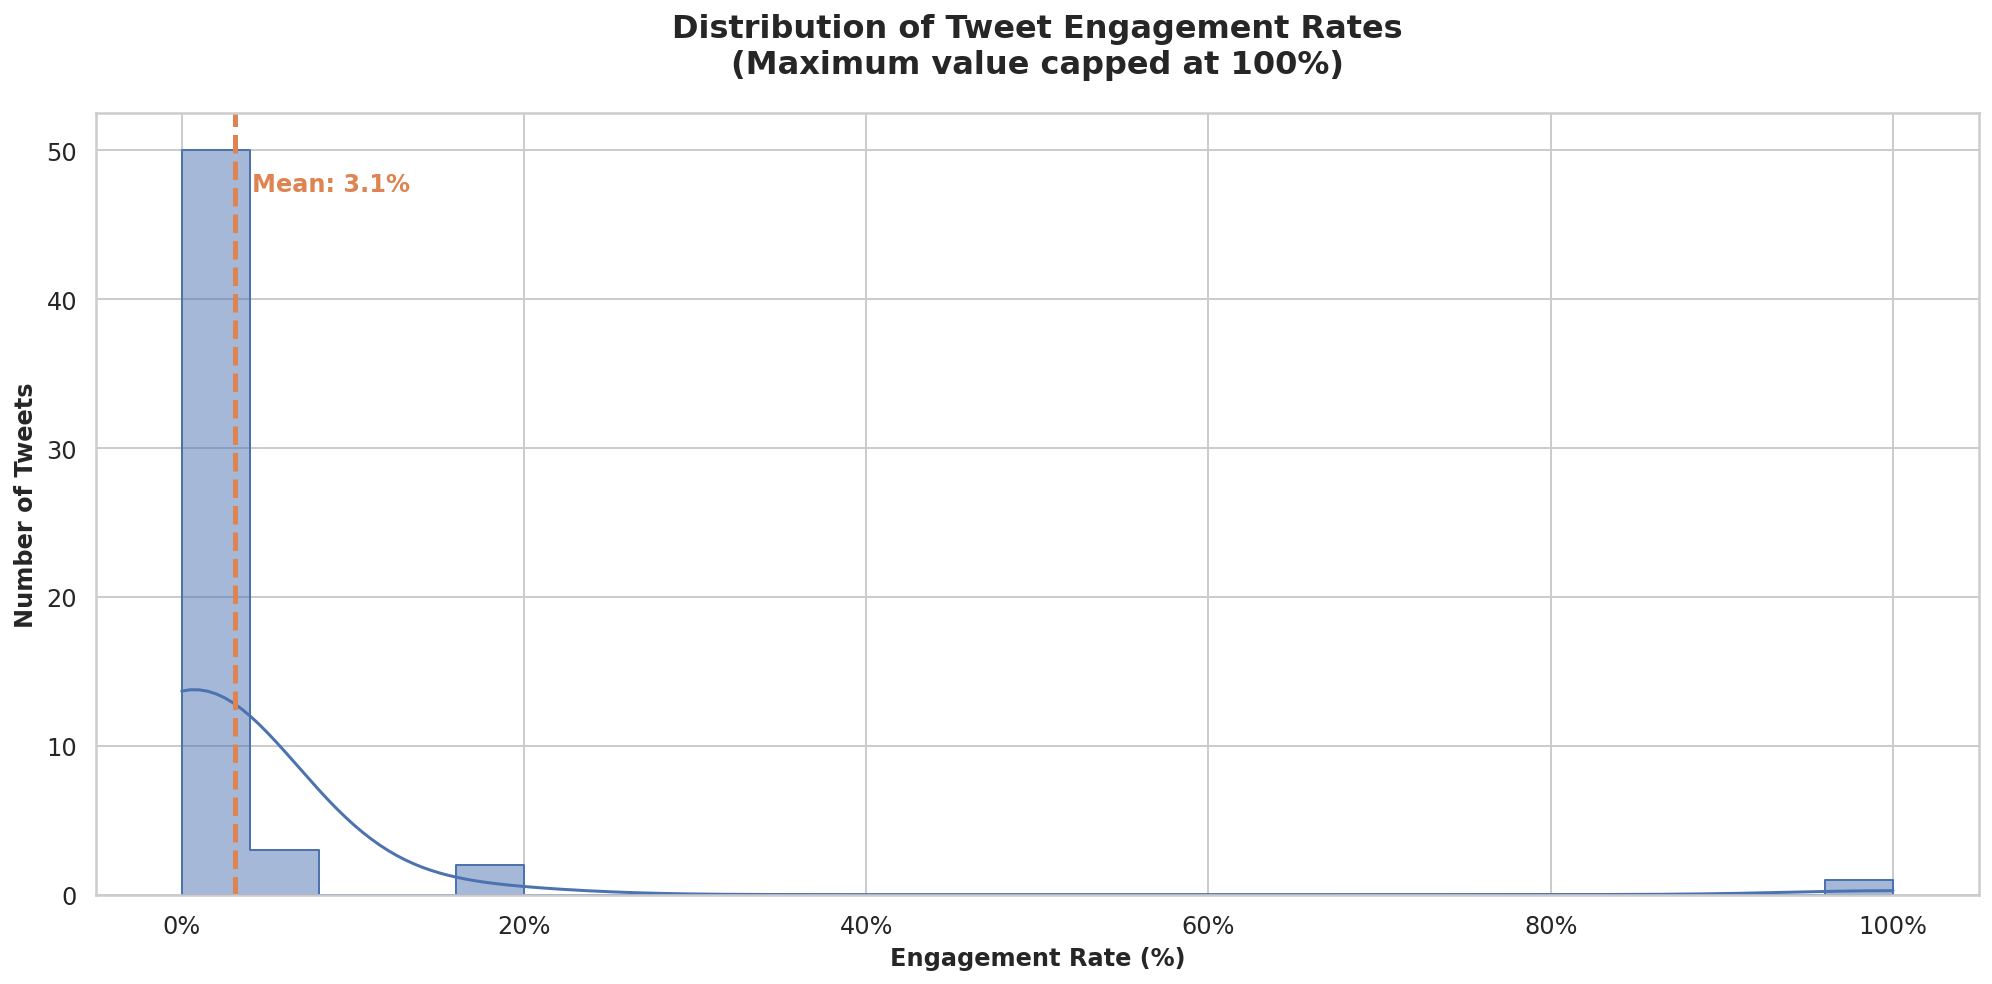

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


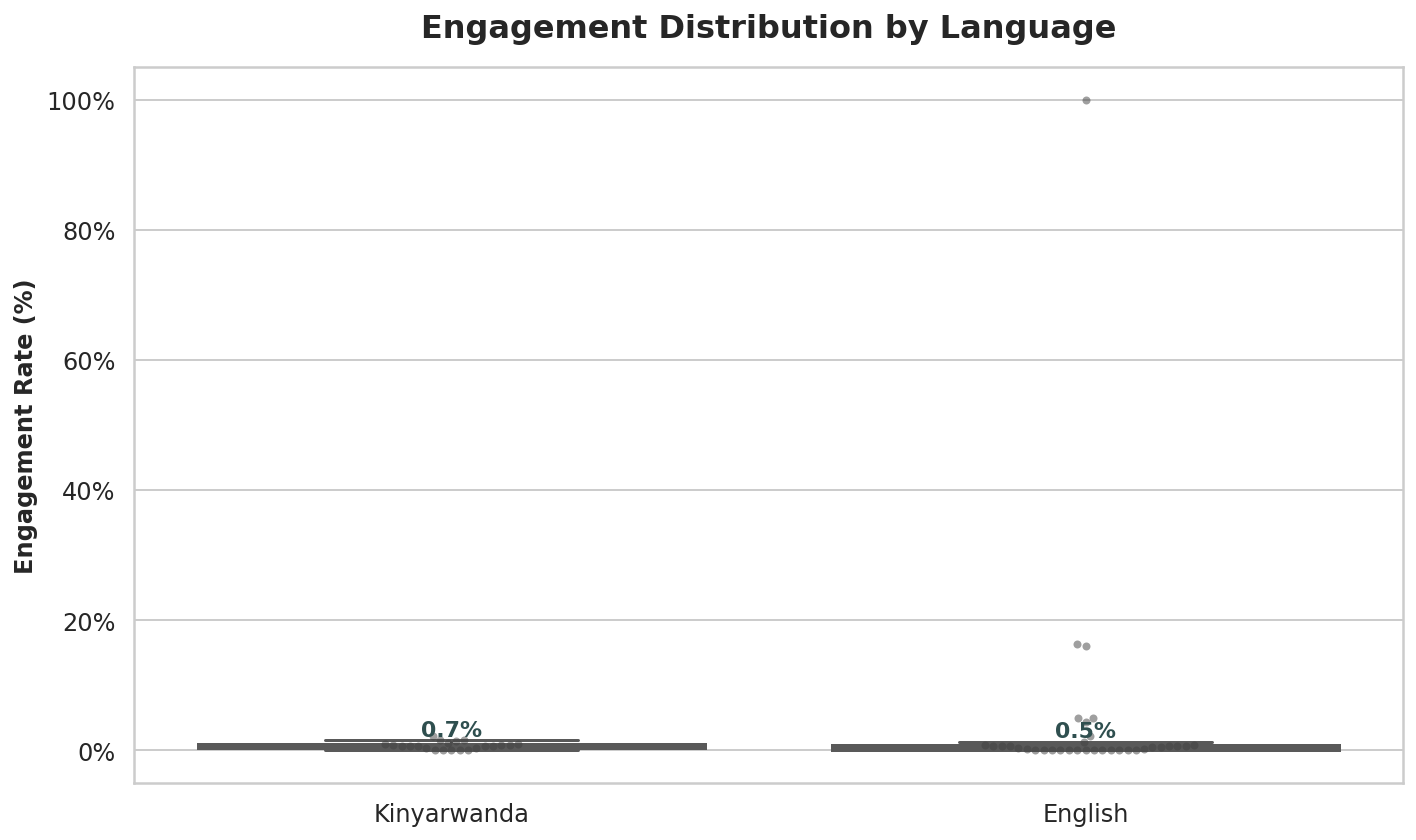

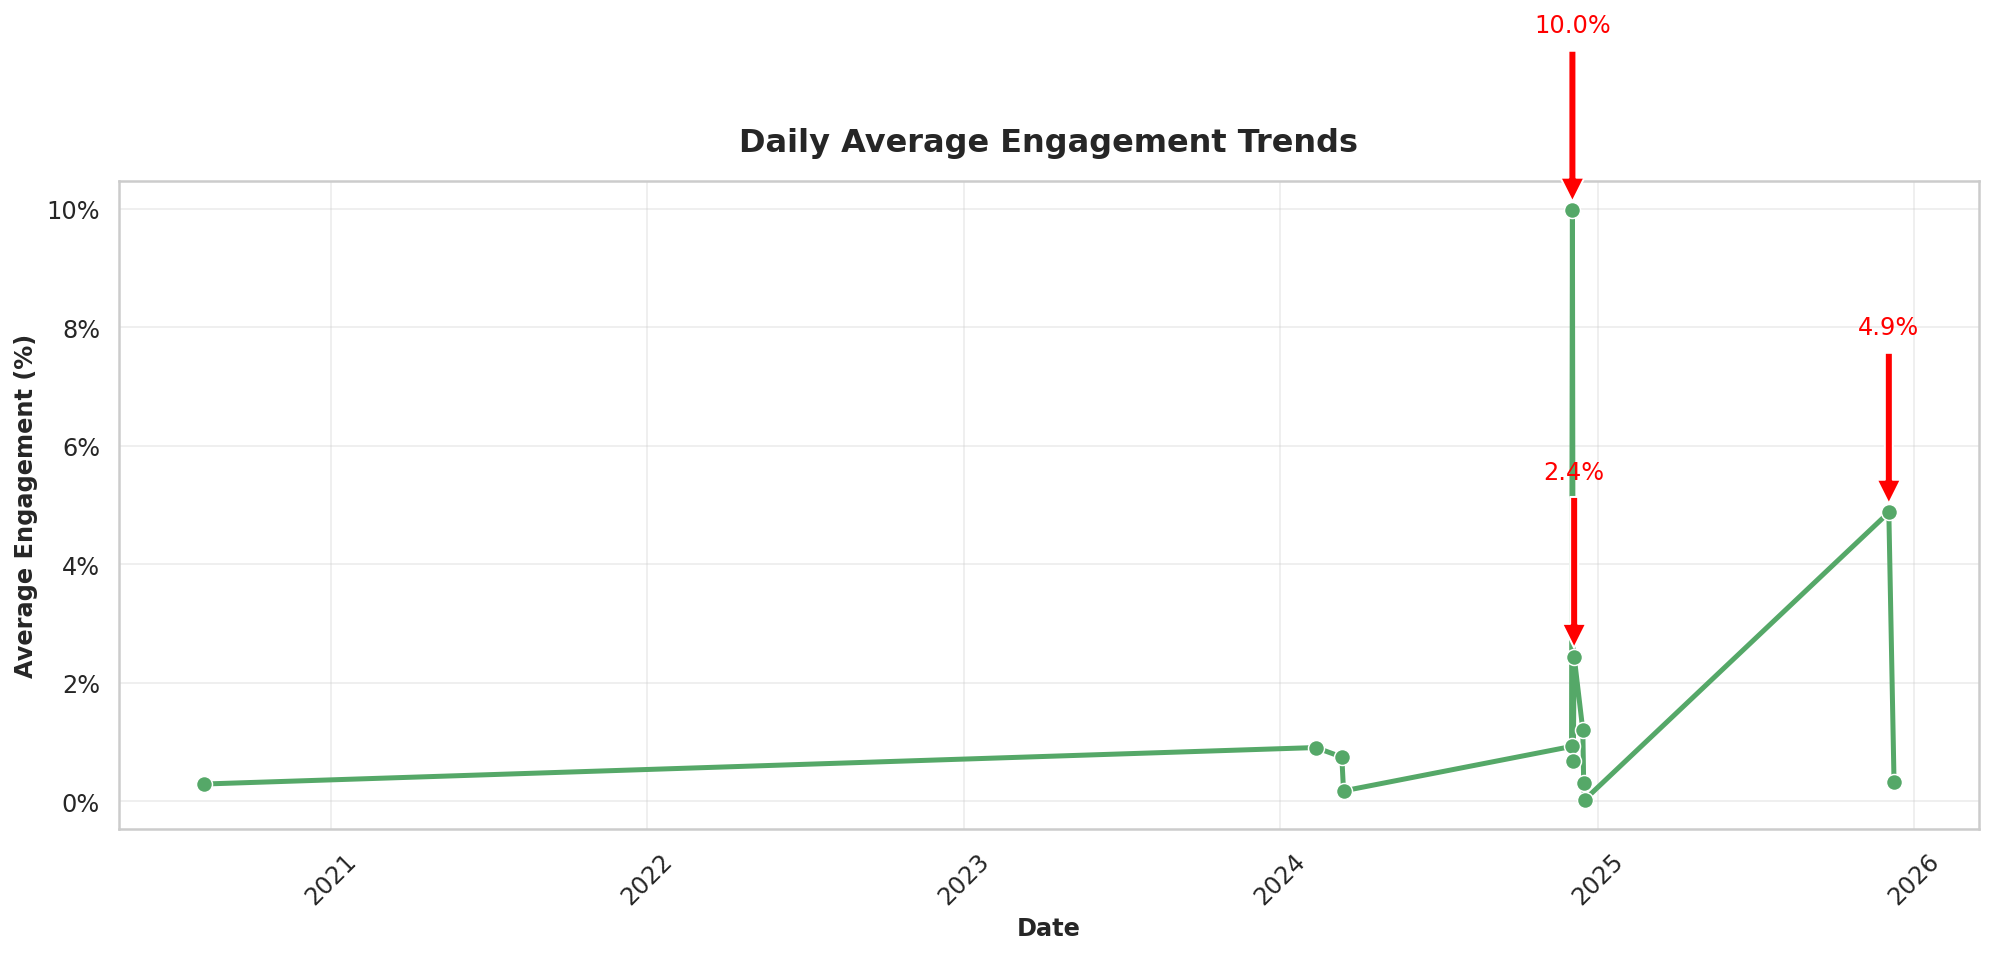

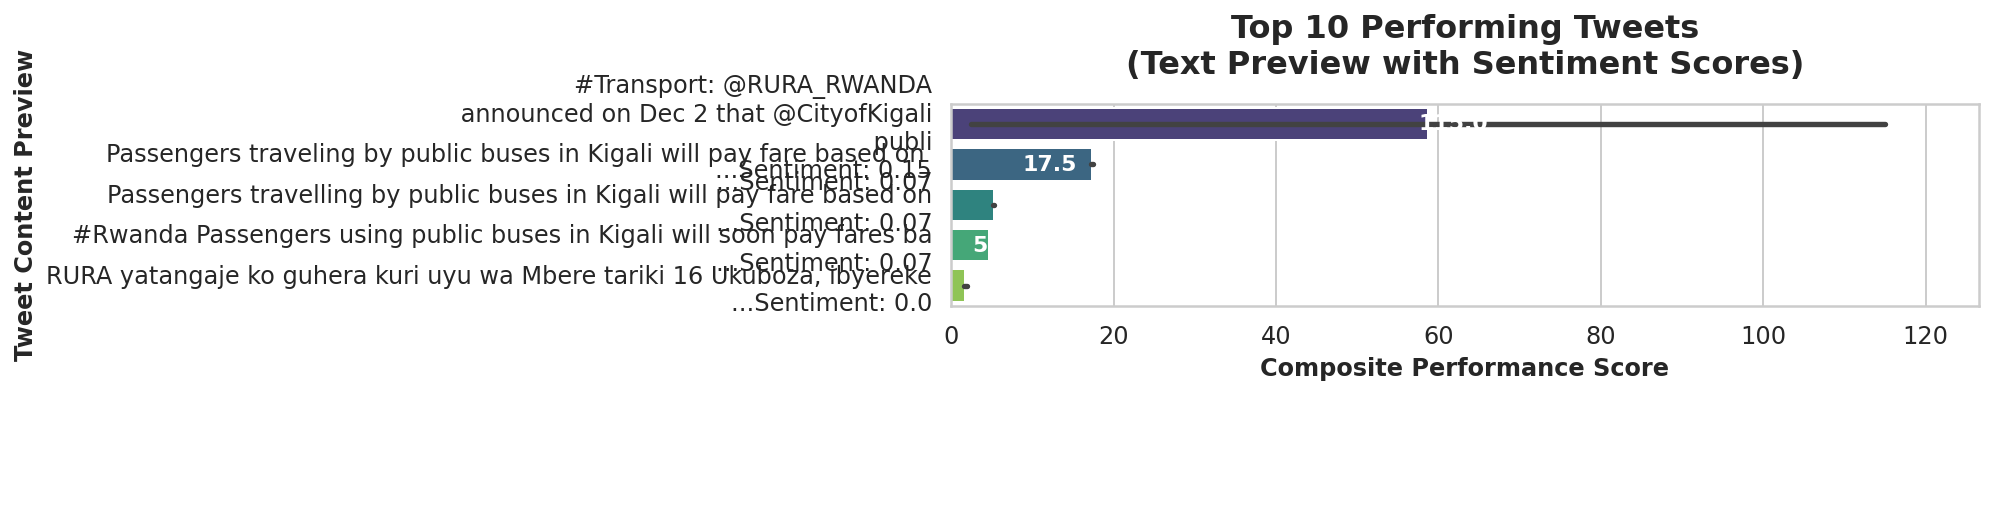


Data processing complete. Saved results to:
- enriched_tweets.csv
- engagement_distribution.png
- language_comparison.png
- temporal_trends.png
- top_performers.png


In [14]:
# 1. IMPORT LIBRARIES WITH STANDARD ALIASES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
from matplotlib.ticker import PercentFormatter, FuncFormatter

# 2. CONFIGURE VISUALIZATION SETTINGS
# ==================================
# Set global styling parameters for all plots
sns.set_theme(
    style="whitegrid",  # Clean grid background
    context="notebook", # Optimize sizing for notebook context
    palette="pastel",   # Soft color palette
    font="DejaVu Sans",# Consistent font
    rc={
        'figure.figsize': (12, 7),          # Default figure size
        'axes.titlesize': 16,              # Title font size
        'axes.titleweight': 'bold',         # Title font weight
        'axes.titlepad': 20,                # Title padding
        'axes.labelweight': 'bold',         # Axis label weight
        'xtick.labelsize': 12,              # X-tick label size
        'ytick.labelsize': 12,              # Y-tick label size
        'figure.dpi': 144                   # High resolution output
    }
)

# Configure warning filters
warnings.filterwarnings(
    action='ignore',
    category=FutureWarning,
    message='use_inf_as_na option is deprecated'
)

# 3. DATA PREPROCESSING (WITH ENHANCED COMMENTS)
# ==============================================
# Load data with explicit error handling
try:
    RAW_PATH = "/kaggle/input/tweets/Tweets.xlsx"
    df = pd.read_excel(RAW_PATH) if RAW_PATH.endswith(('.xlsx', '.xls')) else pd.read_csv(RAW_PATH)
    print(f"Successfully loaded {len(df):,} records from {RAW_PATH}")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# Clean column names using snake_case convention
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

# Temporal analysis preparation
if 'date' in df:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df['day_of_week'] = df['date'].dt.day_name()  # Extract weekday names
    df['hour'] = df['date'].dt.hour               # Extract hour component

# Language standardization
language_map = {
    'eng': 'English',
    'kiny': 'Kinyarwanda',
    'fr': 'French'  # Example of adding new mappings
}
df['language'] = df.get('language', pd.Series()).map(language_map).fillna('Unknown')

# Numeric conversion with error logging
numeric_cols = ['views', 'likes', 'retweets']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Engagement metric calculation with overflow protection
df['engagement'] = (df['likes'] + df['retweets']) / df['views'].replace(0, np.nan)
df['engagement'] = df['engagement'].clip(upper=1.0) * 100  # Cap at 100%

# Sentiment analysis pipeline
if 'text' in df:
    df['sentiment'] = df['text'].apply(
        lambda t: TextBlob(str(t)).sentiment.polarity  # Handle NaN texts
    )
    # Composite score combining engagement and sentiment
    df['final_score'] = df['engagement'] * (1 + df['sentiment'])
else:
    df['sentiment'] = df['final_score'] = 0  # Default values

# 4. ENHANCED VISUALIZATIONS WITH CONTEXTUAL ANNOTATIONS
# ======================================================

def format_engagement(x, pos=None):
    """Custom formatter for engagement percentages"""
    return f"{x:.0f}%"

# A. ENGAGEMENT DISTRIBUTION ANALYSIS
plt.figure(figsize=(14, 7))
ax = sns.histplot(
    data=df.query('engagement <= 100'),  # Exclude outliers
    x='engagement',
    bins=25,
    kde=True,
    element='step',
    color='#4C72B0'
)

# Add statistical annotations
mean_eng = df['engagement'].mean()
ax.axvline(mean_eng, color='#DD8452', linestyle='--', linewidth=2.5)
ax.text(
    x=mean_eng+1, y=ax.get_ylim()[1]*0.9,
    s=f'Mean: {mean_eng:.1f}%',
    color='#DD8452',
    fontsize=12,
    weight='bold'
)

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_engagement))
plt.title(
    "Distribution of Tweet Engagement Rates\n(Maximum value capped at 100%)",
    pad=20
)
plt.xlabel("Engagement Rate (%)")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.savefig('engagement_distribution.png', bbox_inches='tight')
plt.show()

# B. LANGUAGE COMPARISON ANALYSIS
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df,
    x='language',
    y='engagement',
    palette='Set2',
    showfliers=False  # Remove outliers for clearer visualization
)

# Add swarm plot overlay
sns.swarmplot(
    data=df,
    x='language',
    y='engagement',
    color='.25',  # Dark gray points
    size=4,
    alpha=0.5
)

# Calculate and annotate medians
medians = df.groupby('language')['engagement'].median().sort_values(ascending=False)
for i, (lang, med) in enumerate(medians.items()):
    ax.text(
        x=i, 
        y=med+1.5,
        s=f'{med:.1f}%',
        ha='center',
        color='#2F4F4F',
        fontsize=11,
        weight='bold'
    )

plt.title("Engagement Distribution by Language", pad=15)
plt.xlabel("")
plt.ylabel("Engagement Rate (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.tight_layout()
plt.savefig('language_comparison.png', bbox_inches='tight')
plt.show()

# C. TEMPORAL TREND ANALYSIS
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=df.resample('D', on='date')['engagement'].mean().reset_index(),
    x='date',
    y='engagement',
    marker='o',
    markersize=8,
    color='#55A868',
    linewidth=2.5
)

# Highlight peak engagement days
peak_days = df.resample('D', on='date')['engagement'].mean().nlargest(3)
for date, val in peak_days.items():
    ax.annotate(
        f'{val:.1f}%',
        xy=(date, val),
        xytext=(date, val + 3),
        arrowprops=dict(facecolor='red', shrink=0.05),
        horizontalalignment='center',
        color='red'
    )

plt.title("Daily Average Engagement Trends", pad=15)
plt.xlabel("Date")
plt.ylabel("Average Engagement (%)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_trends.png', bbox_inches='tight')
plt.show()

# D. TOP PERFORMERS ANALYSIS
# Prepare text formatting for readability
top10 = df.nlargest(10, 'final_score').copy()
top10['display_text'] = (
    top10['text'].str.slice(0, 70)  # Show first 70 characters
    + '\n...'                       # Add continuation indicator
    + 'Sentiment: ' 
    + top10['sentiment'].round(2).astype(str)
)

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=top10,
    x='final_score',
    y='display_text',
    palette='viridis',
    orient='h'
)

# Add value labels
for i, score in enumerate(top10['final_score']):
    ax.text(
        x=score/2, 
        y=i,
        s=f'{score:.1f}',
        va='center',
        color='white',
        fontsize=11,
        fontweight='bold'
    )

plt.title("Top 10 Performing Tweets\n(Text Preview with Sentiment Scores)", pad=15)
plt.xlabel("Composite Performance Score")
plt.ylabel("Tweet Content Preview")
plt.xlim(0, top10['final_score'].max() * 1.1)
plt.tight_layout()
plt.savefig('top_performers.png', bbox_inches='tight')
plt.show()

# 5. DATA EXPORT
# ==============
df.to_csv("enriched_tweets.csv", index=False)
print("\nData processing complete. Saved results to:")
print("- enriched_tweets.csv")
print("- engagement_distribution.png")
print("- language_comparison.png")
print("- temporal_trends.png")
print("- top_performers.png")